(sec-dask-task-graph)=
# Task Graph and Data Partitioning

In {numref}`get-started-dask-dataframe`, we visualized the Task Graph of a Dask DataFrame. This section explores Dask's Task Graph and data partitioning mechanism.

## Task Graph

Similar to many big data computation frameworks, Dask's computation graph is a Directed Acyclic Graph (DAG), referred to as the Task Graph. It can be visualized using the `.visualize()` method. The Task Graph organizes numerous small computation tasks, known as Tasks, and each Task is executed on a single Worker.

For example, consider the following example, which consists of two types of tasks: `data(i)` receives input data, and `add(x, y)` performs addition on two input values `x` and `y`.

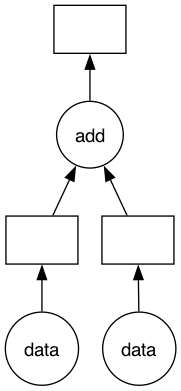

In [12]:
import dask.delayed as delayed

def data(i):
    return i

def add(x, y):
    return x + y

x = delayed(data)(1)
y = delayed(data)(2)
z = delayed(add)(x, y)

z.visualize(filename='../img/ch-dask/visualize.svg')

In [13]:
z = z.compute()
print(z)

3


In this example, the Dask Task Graph consists of three tasks: two data input tasks and one addition task. Dask breaks down complex parallel computations into tasks, where each task is a Python function. In the visualized Task Graph produced by `visualize()`, circles represent functions, and rectangles represent data placeholders.
Dask Scheduler generates the Task Graph and distributes computation tasks to Dask Workers.

It is worth noting that when combining multiple tasks, here we utilize `dask.delayed`. `dask.delayed` is a more low-level interface that allows users to manually construct a computation graph. If users want to customize certain tasks, they may employ the `dask.delayed` decorator, as follows:

```
@dask.delayed
def f(x):
    x = x + 1
    return x
```

One should use: `dask.delayed(f)(x, y)`, rather than `dask.delayed(f(x, y))`, because `dask.delayed` is intended to decorate Python functions, not the output of the functions. Python functions decorated by `dask.delayed` will form a node in the Task Graph. Dask does not create a new computation engine but organizes multiple tasks through the Task Graph. All the APIs and features provided by Dask are implemented based on this approach.

## Data Partitioning

Dask divides large datasets into many smaller pieces. Dask Array refers to these sliced pieces as "chunks," and Dask DataFrame refers to them as "partitions." Although chunks and partitions differ, they represent the decomposition of big data.

The following example is a computation where a $10 \times 10$ matrix is split into four $5 \times 5$ matrices.

In [2]:
import dask.array as da
x = da.ones((10, 10), chunks=(5, 5))

y = x + x.T
y

dask.array<add, shape=(10, 10), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

After the data partitioning, there are a total of four chunks, and Dask assigns indices to these four chunks, namely: (0, 0), (0, 1), (1, 0), (1, 1). Each chunk invokes NumPy for computation. When necessary, aggregations are performed on multiple chunks. The following graph illustrates the Task Graph for this matrix operation.

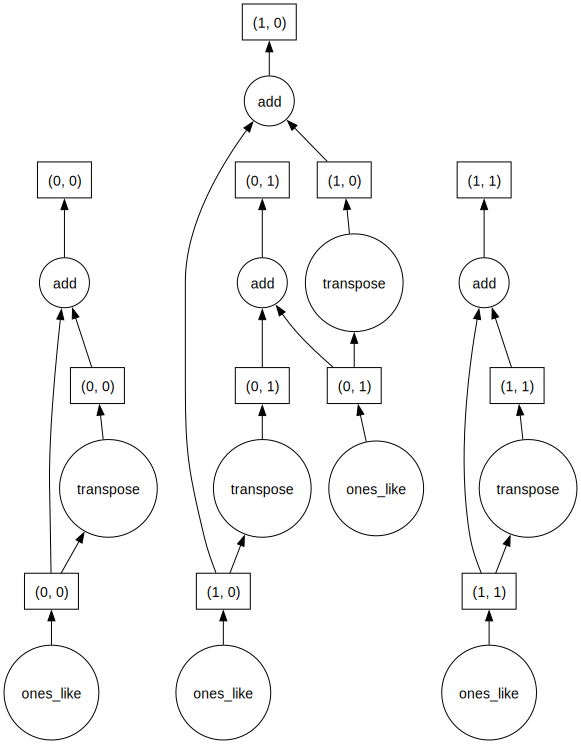

In [3]:
y.visualize(filename='../img/ch-dask/transpose.svg')

In this Task Graph, circles represent computation functions, for example, ones_like corresponds to NumPy's `np.ones_like()` method, and transpose represents NumPy's `np.transpose()` method. Rectangles represent data placeholders, indicating NumPy data blocks obtained from the previous computation steps.

## Data Partitioning Granularity

The granularity of data partitioning affects the Task Graph:

* If each data block is small, the Task Graph will be large.
* If each data block is large, the Task Graph will be small.

Data blocks that are too large or too small are not optimal. Here we give some explanation and you can refer to [the Dask blog on this topic](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes).

### Data Blocks Too Small

If the data blocks are too small, the Task Graph will be large. According to Dask's statistics, Dask Scheduler takes an average of 1 millisecond to coordinate and distribute a computation task in the Task Graph. If the Task Graph is large, Dask will spend a significant amount of time on coordinating and distributing computation resources.

To use an analogy, the Dask Scheduler is the supervisor, and Dask Workers are human workers. Suppose we need to build a wall with many bricks, and the workers are responsible for moving the bricks onto the wall. If the supervisor arranges tasks such that each worker moves only one brick at a time, a considerable amount of time is wasted on back-and-forth movement. This doesn't fully utilize the capabilities of the workers, and the supervisor is overwhelmed with instructing individual workers.
In the case of small data blocks, Dask Workers are underutilized, and Dask Scheduler has a heavy workload distributing tasks. In this case, Dask typically logs hints informing users that the Task Graph is too large, affecting performance and prompting users to optimize the data partitioning method.

### Data Blocks Too Large

If data blocks are too large, Dask Workers are prone to running out of memory (OOM) because an individual Dask Worker cannot handle the large data block. When faced with OOM, Dask spills some data to disk. If the computation still cannot be completed after spilling, the Dask Worker may be restarted, potentially leading to repeated restarts.

## Iterative Algorithms

Iterative algorithms typically use loops, i.e., the current iteration depends on the data from the previous iterations. Dask's Task Graph does not handle iterative algorithms well. Each data dependency adds a directed edge to the Task Graph, which can make the Task Graph very large and cause slow execution speed. For example, many machine learning algorithms and SQL JOIN operations are based on iterative algorithms.

## Setting the Right Data Block Size

In summary, when partitioning data into blocks, the size should neither be too large nor too small. There is no one-size-fits-all setting in Dask, and developers need to adjust based on their data and monitor Dask's dashboard or logs.

### Dask Dashboard
As shown in {numref}`dask-dashboard`, the Dask dashboard provides real-time information about tasks. Users can adjust data partitioning based on the information available on the dashboard.

```{figure} ../img/ch-dask/dask-dashboard.png
---
width: 800px
name: dask-dashboard
---
Dask Daskboard
```
We should pay attention to the Task Stream column and avoid having a large amount of white space or a significant amount of red. White space indicates that there are no tasks on a Dask Worker, while red indicates substantial data exchange between Dask Workers.

{numref}`dask-good-partitions` and {numref}`dask-too-many-partitions` illustrate that both cases use the same code ({numref}`sec-dask-dataframe-read-write` example), but with different data block sizes. In {numref}`dask-too-many-partitions`, where the data blocks are too small, the Task Graph is excessively large, leading to a significant amount of red. This means time is not spent on computation but is instead wasted on tasks like data exchange.

```{figure} ../img/ch-dask/good-partitions.png
---
width: 600px
name: dask-good-partitions
---
A normal Task Stream
```

```{figure} ../img/ch-dask/too-many-partitions.png
---
width: 600px
name: dask-too-many-partitions
---
Each partition being too small results in an excessively large Task Graph, leading to time being wasted on activities like data exchange rather than actual computation.
```

In terms of memory, it's advisable to avoid orange, gray, or red in the memory graph. Gray or red indicates that the data blocks are too large, surpassing the memory capacity of Dask Workers. {numref}`dask-memory` illustrates memory usage.

<table>
    <tr>
        <td>
            <div role="img" aria-label="blue square" style="color:rgba(0, 0, 255, 1); font-size: 25px ">&#9632;</div>
        </td>
        <td>Memory under target (default 60% of memory available)</td>
    </tr>
    <tr>
        <td>
            <div role="img" aria-label="orange square" style="color:rgba(255, 165, 0, 1); font-size: 25px ">&#9632;</div>
        </td>
        <td>Memory is close to the spilling to disk target (default 70% of memory available)</td>
    </tr>
    <tr>
        <td>
            <div role="img" aria-label="red square" style="color:rgba(255, 0, 0, 1); font-size: 25px ">&#9632;</div>
        </td>
        <td>When the worker (or at least one worker) is paused (default 80% of memory available) or retiring</td>
    </tr>
    <tr>
        <td>
            <div role="img" aria-label="grey square" style="color:rgba(128, 128, 128, 1); font-size: 25px ">&#9632;</div>
        </td>
        <td>Memory spilled to disk</td>
    </tr>
</table>

```{figure} ../img/ch-dask/dashboard-memory.gif
---
width: 600px
name: dask-memory
---
Dask Dashboard of memory usage
```

### Setting the Data Block Size

Dask Array and Dask DataFrame both provide ways to set the data block size.

You can specify the size of each data block during initialization, for example: `x = da.ones((10, 10), chunks=(5, 5))`. The `chunks` parameter is used to set the size of each data block. It's also possible to adjust it after initialization, using methods like Dask Array's [`rechunk()`](https://docs.dask.org/en/latest/generated/dask.array.rechunk.html) and Dask DataFrame's [`repartition()`](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.repartition.html). In Dask Array, you can use the `rechunk(chunks=...)` method to set the size of data chunks after the data is created, and the `chunks` parameter can be an `int` indicating the number of data chunks to split into, or it can be a tuple like `(5, 10, 20)`, representing the dimensions of a single data chunk. In Dask DataFrame, you can use the `repartition(npartitions=...)` method to set the number of data partitions.